# 01 - Baseline Strategy

Chunking documents based on different strategies will result in significant differences in search relevance. These differences vary based on the length of the documents being chunked. With the baseline strategy we will split documents into discrete chunks of length 400 words. We expect to get results that are reasonable.

For more information on this experiment and it's out

## RAGE-1: RAG Experiment 

### Setting up the Experiment

Having ran [00-Chunking Strategies](./00-Chunking%20Strategies.ipynb) we now have our base data and our evaluation dataset. Now it's time to run our first experiment!

Given a dataframe containing our chunked documents we must:

- Chunk the documents
- Embed the chunks
- Store it in a vector database.
- Query the db using our ground truth (GT) question answer pairs.
- Create a generation prompt which includes the question, and the retrieved "context".
- Run the generation prompt and store the Question, Answer, GT Answer, Context for our evaluation framework.

Let's follow our [baseline experiment](experiments/01-chunking-strategies-baseline.md). 

In [1]:
import pandas as pd
from pathlib import Path
import mlflow
import os

# Params
top_k = 5
chunk_size = 600
chunk_overlap = 50

# Models
generation_model = os.getenv('GEN_STEP_MODEL')
evaluation_model = os.getenv('EVAL_STEP_MODEL')

# Experiment
experiment_name = f"baseline_pubmed_articles_{chunk_size}_{chunk_overlap}_{top_k}"
evaluation_data = pd.read_csv('data/qa_pairs.csv')
input_data = pd.read_csv('data/docs_subset.csv')

# Check if the experiment already exists
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    # If the experiment does not exist, create it
    experiment_id = mlflow.create_experiment(
        experiment_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
        tags={"version": "v1", "priority": "P1"},
    )
else:
    # If the experiment exists, get its ID
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_id)
   

2024/04/30 23:03:51 INFO mlflow.tracking.fluent: Experiment with name '926817954221398219' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/guybourne/projects/chunky_monkey/chunking_strategies/mlruns/229372306398634800', creation_time=1714482231125, experiment_id='229372306398634800', last_update_time=1714482231125, lifecycle_stage='active', name='926817954221398219', tags={}>

#### Chunking the documents

Based on our earlier analysis, let's take a chunk size of 400 words with an overlap of 50. We can calculate the exact length of requests later, but 400 words is approximately 500 tokens per chunk based on our analysis and we should be able to fit multiple results into our context.

In [2]:
from rag.chunking import chunk_string_with_overlap

if os.path.exists(f'data/{experiment_name}-chunks.csv'):
    print(f"Chunked data already exists at data/{experiment_name}-chunks.csv")
    ds_chunked = pd.read_csv(f'data/{experiment_name}-chunks.csv')
    print(f"Loaded {len(ds_chunked)} chunks")

else:
    # Create a new DataFrame with each chunk as a separate row
    chunks = []
    doc_ids = []
    chunk_ids = []
    for idx, row in input_data.iterrows():
        article_chunks = chunk_string_with_overlap(input_text=row['article'], chunk_length=400, overlap=50)
        chunks.extend(article_chunks)
        doc_ids.extend([row['doc_id']] * len(article_chunks))
        chunk_ids.extend([f"{row['doc_id']}-{i+1}" for i in range(len(article_chunks))])

    ds_chunked = pd.DataFrame({'doc_id': doc_ids, 'chunk_id': chunk_ids, 'chunks': chunks})
    ds_chunked.to_csv(f'data/{experiment_name}-chunks.csv', index=False)


Let's take a look at some of our chunks - it helps to do a sense check as if we see something wrong, it's a lot easier to fix now than after creating your embeddings and search indexes.

In [3]:
from pprint import pprint

# display a random sample of the chunked data show the full string
for chunk in ds_chunked['chunks'].sample(5):
    pprint(chunk)
    print('\n') 

('the diagnosis is made histologically and usually refers to a neutrophilic '
 'infiltration around the eccrine sweat glands and mostly around the proximal '
 'portion coils . neh is usually described in relation to other neutrophilic '
 'dermatoses , a group of skin diseases characterized by an infiltration of '
 'the skin by normal polymorphonuclear neutrophils no infectious or other '
 'causes are identified ; thus , its clinical aspect makes neh sometimes '
 'difficult to distinguish from the sweet syndrome , an entity that will not '
 'be addressed in detail in this article . neh is a rare condition , though '
 'epidemiology was not precisely studied for this condition . neutrophilic '
 'dermatoses in granulocytopenic patients receiving chemotherapy occur at an '
 'incidence rate of 2.6% ( according to an article published in 1995 ) . '
 'furthermore , some case reports describe a facial neh that can mimic '
 'cellulitis . for these patients , proper recognition of neh can prevent

Already we can see that sentences are broken, and that perhaps this isn't a great way of splitting our information. That being said we are generating a baseline and we expect the subsequent experiments to offer significant uplift. For now let's proceed.

> KEY TAKEAWAY: Even before we've run expensive and time consuming API calls, we can see that the results are not ideal. It's often worth iterating on this before investing time and money in the more nuanced tuning approaches.

#### Embed the chunks

We will use the `ada-v2` embedding model for this example as it is fairly powerful and well understood. It's worth noting that this will not always be the best model, paticularly when data contains topics and content that relate to finding outside of the embedding model's training data. Fine tuning an embedding model on a specific corpus (particularly in the case of highly specialised data) is also a popular option.

Most vector databases implement a wrapper around common embedding functions. Here we will configure and use the wrapper for openai embeddings in ChromaDB. This function is used to embed all documents in a collection, and also to embed queries as they come in.

In creating the index, we also need to specify the measurement method. For illustratice purposes we've used cosine similarity. In reality, for enterprise use cases index design is a rich topic in itself. Again, call out if you'd like more content on index design and choice of search engine! 

> KEY TAKEAWAY: Your choice of embedding model matters! It should be consistent across your index. and should be relevant to your data.


In [4]:
import chromadb.utils.embedding_functions as embedding_functions
from dotenv import find_dotenv, load_dotenv
import os

load_dotenv(find_dotenv())   
# Specify Embedding model
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")

# Used in chromadb to embed docs and queries
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_type="azure",
                api_version=os.getenv("OPENAI_API_VERSION"),
                model_name=embedding_model
            )
# Create a new collection in ChromaDB
from chromadb import PersistentClient

chroma_client = PersistentClient(path="./data/chroma_db")

index_name = f"experiment_{experiment_name}"
collection = chroma_client.get_or_create_collection(name=index_name,embedding_function=openai_ef, metadata={"hnsw:space": "cosine"})

collection.add(
    # embeddings=ds_chunked['ada_v2'].tolist(),
    documents=ds_chunked['chunks'].tolist(),
    metadatas=[{"doc_id": doc_id} for doc_id in ds_chunked['doc_id']],
    ids=ds_chunked['chunk_id'].tolist()
    )    

Now let's take a quick look at an example question and the response.

In [5]:
from pprint import pprint

results = collection.query(
    query_texts=[evaluation_data['question'][3]],
    n_results=top_k)

print(evaluation_data['question'][3])
pprint(results)


What factors did the study adjust for when estimating the hazard ratios (HRs) for the incidence of type 2 diabetes?
{'data': None,
 'distances': [[0.13403910398483276,
                0.14559274911880493,
                0.1472933292388916,
                0.14976882934570312,
                0.15260815620422363]],
 'documents': [['the annual health checkup included measurement of height , '
                'body weight , and blood pressure and a urinary glucose test . '
                ', participants were followed for the development of type 2 '
                'diabetes , which was based on any one of the following three '
                'diagnostic parameters : 1 ) plasma glucose levels exceeded '
                '11.1 mmol / l ( 200 mg / dl ) 2 h after an oral glucose '
                'tolerance test , conducted in men with urinary glucose '
                'detected at a follow - up annual health checkup , 2 ) '
                'participants themselves reported current therapy 

We can see that the query returns the ID's, scores (distances), metadata and documents (chunks) for the top 5 documents in the collection when scored by cosine similarity. The chunks will form our context, and we will use the metadata for lineage. In our case, we see that there are a number of chunks from the same document - this can be seen as a positive indicator given our corpus is quite specific and documents can be distinct. 

> NOTE: It will depend on your use case and data whether there is a concept of "the right doc"

Now let's take a look at our augmentation and generation steps and apply this at scale!

#### Augmentation and Generation

Here we are enriching the question with the new (and hopefully relevant!) context we have unearthed from the vector database. To do that, we'll need another prompt template. Once we have this, we can submit the prompt to our generation model and receive the answer to our question.

Let's use the previous example.

In [6]:
from rag.augmentation import get_context, contruct_prompt

context = get_context(evaluation_data['question'][3], collection, top_k)
prompt = contruct_prompt(context, evaluation_data['question'][3])

print(prompt)


        You provide answers to questions based on information available. You give precise answers to the question asked.
        You do not answer more than what is needed. You are always exact to the point. You Answer the question using the provided context.
        If the answer is not contained within the given context, say 'I dont know.'. 
        The below context is an excerpt from a report or data.
        Answer the user question using only the data provided in the sources below.

        CONTEXT:
        ['the annual health checkup included measurement of height , body weight , and blood pressure and a urinary glucose test . , participants were followed for the development of type 2 diabetes , which was based on any one of the following three diagnostic parameters : 1 ) plasma glucose levels exceeded 11.1 mmol / l ( 200 mg / dl ) 2 h after an oral glucose tolerance test , conducted in men with urinary glucose detected at a follow - up annual health checkup , 2 ) participants 

We can see that we've created a new prompt that's ready to be submited to our generation model. Let's take a look at a single call.

In [7]:
from helper.openai_utils import general_prompt, create_client

oai_client = create_client()

response = general_prompt(oai_client, prompt, model=generation_model)

print(f"Question: {evaluation_data['question'][3]}")
print(f"Correct Answer: {evaluation_data['ground_truth'][3]}")

print(f"Generated Answer: {response}")

Question: What factors did the study adjust for when estimating the hazard ratios (HRs) for the incidence of type 2 diabetes?
Correct Answer: The study adjusted for age, initial fitness level (continuous VO2max), BMI, systolic blood pressure, cigarette smoking, alcohol intake, and a family history of diabetes.
Generated Answer: The study adjusted for age, initial fitness level (continuous VO2max), BMI (continuous variable), systolic blood pressure (continuous variable), cigarette smoking (nonsmokers, 120 cigarettes/day, and 21 cigarettes/day), alcohol intake (none, 145 g/day, and 46 g/day), and a family history of diabetes (present or not).


This is looking pretty good! What you've likely just experienced is the infamous "vibe check" for LLM based applications. We'll get on to more formal measurement soon. But first, let's get answers to all 250 questions.

> NOTE: The execution time of this will heavily depend on your model selection. For GPT-35-turbo-16k it should complete in roughly 3 minutes.

In [8]:
from multiprocessing import Pool

multi_threading = True


if os.path.exists(f'data/{experiment_name}-{generation_model}-results.csv'):
    print("File exists, reading in...")
    import os
    import ast
    import pandas as pd
    from dotenv import find_dotenv, load_dotenv

    load_dotenv(find_dotenv())

    results_df = pd.read_csv(f'data/{experiment_name}-{generation_model}-results.csv')

    # Convert the contexts to a list of strings using ast
    results_df['contexts'] = results_df['contexts'].apply(ast.literal_eval)

else:
    #Create a distinct copy of evaluation_data to store the results
    results_df = evaluation_data.copy()

    def generation_step(question):
        context = get_context(question, collection,top_k)
        prompt = contruct_prompt(context, question)
        return general_prompt(oai_client, prompt, model=generation_model)

    if multi_threading == True:
        with Pool() as pool:
            results_multiprocessing = pool.map(generation_step, results_df['question'])
        results_df['answer'] = results_multiprocessing

    else:
        results_df['answer'] = results_df['question'].apply(lambda x: generation_step(x))

    #TODO: Refactor this so only one call for context

    # Check if the column exists
    if 'contexts' not in results_df.columns:
        results_df['contexts'] = [get_context(q, collection) for q in results_df['question']]

    #write out to CSV
    results_df.to_csv(f'data/{experiment_name}-{generation_model}-results.csv', index=False)

display(results_df.head())

File exists, reading in...


,question,ground_truth,answer,contexts
0,How were participants screened for exclusion i...,Participants were excluded if they had diabete...,Participants were screened for exclusion in th...,"[coefficient of 0.92 ( 16 ) . furthermore , we..."
1,What were the initial exercise loads for the s...,The initial exercise loads were 600 kilopond m...,The initial exercise loads for the submaximal ...,[participants were employees of the tokyo gas ...
2,What method was used to estimate maximal oxyge...,Maximal oxygen uptake (VO2max) was estimated u...,The method used to estimate maximal oxygen upt...,"[4049 years , respectively . heart rate was ca..."
3,What factors did the study adjust for when est...,"The study adjusted for age, initial fitness le...","The study adjusted for age, initial fitness le...",[the annual health checkup included measuremen...
4,What was the relationship between long-term fi...,There was a strong inverse relationship betwee...,The relationship between long-term fitness tre...,"[coefficient of 0.92 ( 16 ) . furthermore , we..."


Now we have a dataframe with the questions, true answers, generated answers, and the context used to generate them, we can start to look at whether or not the answers are any good. To do that, we'll use a popular open source LLM evaluation framework called [Ragas](https://docs.ragas.io/en/stable/).

## RAGE-2: RAG Evaluation Harness

Let's see how well our application performs. We'll be using the following measures to evaluate our results:

1. *Faithfulness*: This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

2. *Answer Relevancy*: The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy.

3. *Answer Semantic Similarity*: The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.

For more information on how these are calculated you can visit the documentation [here](https://docs.ragas.io/en/stable/concepts/metrics/index.html#ragas-metrics).

In [9]:
import json
from eval.evaluate import ragas_evaluate

# check if csv and json files exist
if (os.path.exists(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv') and 
    os.path.exists(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json')):

    print("File exists, reading in...")
    pd_results = pd.read_csv(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv')
    
    with open(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json', 'r') as f:
        results = json.load(f)


else:
# Calculate metrics and store
    results = ragas_evaluate(results_df,evaluation_model=evaluation_model)
    with open(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json', 'w') as f:
        json.dump(results, f)
    pd_results = results.to_pandas()
    pd_results.to_csv(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv', index=False)

from pprint import pprint
pprint(results)
display(pd_results)

File exists, reading in...
{'answer_relevancy': 0.9551145248605175,
 'answer_similarity': 0.925826854390457,
 'faithfulness': 0.9563758025109408}


,question,ground_truth,answer,contexts,faithfulness,answer_relevancy,answer_similarity
0,How were participants screened for exclusion i...,Participants were excluded if they had diabete...,Participants were screened for exclusion in th...,"['coefficient of 0.92 ( 16 ) . furthermore , w...",NaN,1.000000,0.979600
1,What were the initial exercise loads for the s...,The initial exercise loads were 600 kilopond m...,The initial exercise loads for the submaximal ...,['participants were employees of the tokyo gas...,0.928119,1.000000,0.936128
2,What method was used to estimate maximal oxyge...,Maximal oxygen uptake (VO2max) was estimated u...,The method used to estimate maximal oxygen upt...,"['4049 years , respectively . heart rate was c...",0.956235,1.000000,1.000000
3,What factors did the study adjust for when est...,"The study adjusted for age, initial fitness le...","The study adjusted for age, initial fitness le...",['the annual health checkup included measureme...,0.990038,1.000000,0.984925
4,What was the relationship between long-term fi...,There was a strong inverse relationship betwee...,The relationship between long-term fitness tre...,"['coefficient of 0.92 ( 16 ) . furthermore , w...",0.957285,1.000000,0.989519
...,...,...,...,...,...,...,...
245,What is the role of determining a biomolecule'...,Determining a biomolecule's three-dimensional ...,The role of determining a biomolecule's three-...,"[""the determination of a biomolecule 's comple...",1.000000,1.000000,0.981969
246,How does MAVL/StickWRLD contribute to the visu...,MAVL/StickWRLD visualizes interpositional depe...,MAVL/StickWRLD contributes to the visualizatio...,['option in many protein families results in t...,1.000000,0.995033,0.958678
247,What are the three significant improvements of...,The three significant improvements include enh...,The three significant improvements of the new ...,"[""comment on possible structural implications ...",1.000000,1.000000,0.925412
248,How does the MAVL/StickWRLD Java interface fac...,The MAVL/StickWRLD Java interface facilitates ...,The MAVL/StickWRLD Java interface facilitates ...,['option in many protein families results in t...,1.000000,0.897658,0.964604


In [10]:
# Log information to MLFlow

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param("experiment_name", experiment_name)
    mlflow.log_param("top_k", top_k)
    mlflow.log_param("embedding_model", embedding_model)
    mlflow.log_param("generation_model", generation_model)
    mlflow.log_param("evaluation_model", evaluation_model)

    mlflow.log_metric("failthfulness", results['faithfulness'])
    mlflow.log_metric("answer_relevancy", results['answer_relevancy'])
    mlflow.log_metric("answer_similarity", results['answer_similarity'])


Whilst we could manually inspect and track the results, it's best practice to use a tool like MLFlow which can log parameters, artefacts and performance metrics. Here we will track locally, but in practice a team could collaborate and share results in a hosted MLFlow service; for example in Azure Machine Learning.

We can view the results in a UI by running the following command in the terminal, or use the cell below:

`mlflow server --host 127.0.0.1 --port 8080`

Note that you can use any port which isn't already in use.

In [11]:
# You can run it from this cell if you like!

!mlflow server --host 127.0.0.1 --port 8080

/Users/guybourne/miniconda3/envs/chunks/lib/python3.11/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[2024-04-30 23:05:04 +1000] [15014] [INFO] Starting gunicorn 21.2.0
[2024-04-30 23:05:04 +1000] [15014] [INFO] Listening at: http://127.0.0.1:8080 (15014)
[2024-04-30 23:05:04 +1000] [15014] [INFO] Using worker: sync
[2024-04-30 23:05:04 +1000] [15015] [INFO] Booting worker with pid: 15015
[2024-04-30 23:05:04 +1000] [15016] [INFO] Booting worker with pid: 15016
[2024-04-30 23:05:04 +1000] [15017] [INFO] Booting worker with pid: 15017
[2024-04-30 23:05:04 +1000] [15018] [INFO] Booting worker with pid: 15018
^C
[2024-04-30 23:05:29 +1000] [15014] [INFO] Handling signal: int
[2024-04-30 23:05:29 +1000] [15017] [INFO] Worker exiting (pid: 15017)
[2024-04-30 23:05:29 +1000] [15015] [INFO] Worker exiting (pid: 15015)
[2024-04-30 23:05:29 +1000] 

You should now be able to view the experiments, their associated runs and metrics. Select an experiment, and then the associated run to see the detail. This will get more interesting as we run more experiments.

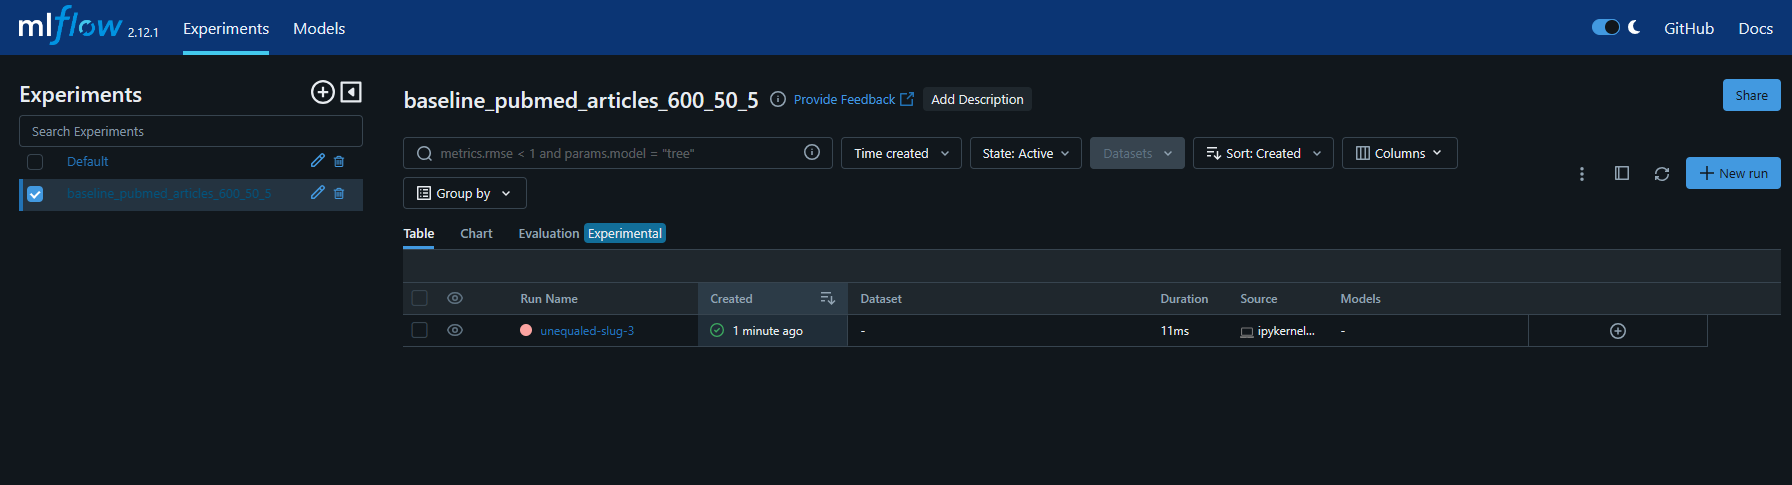

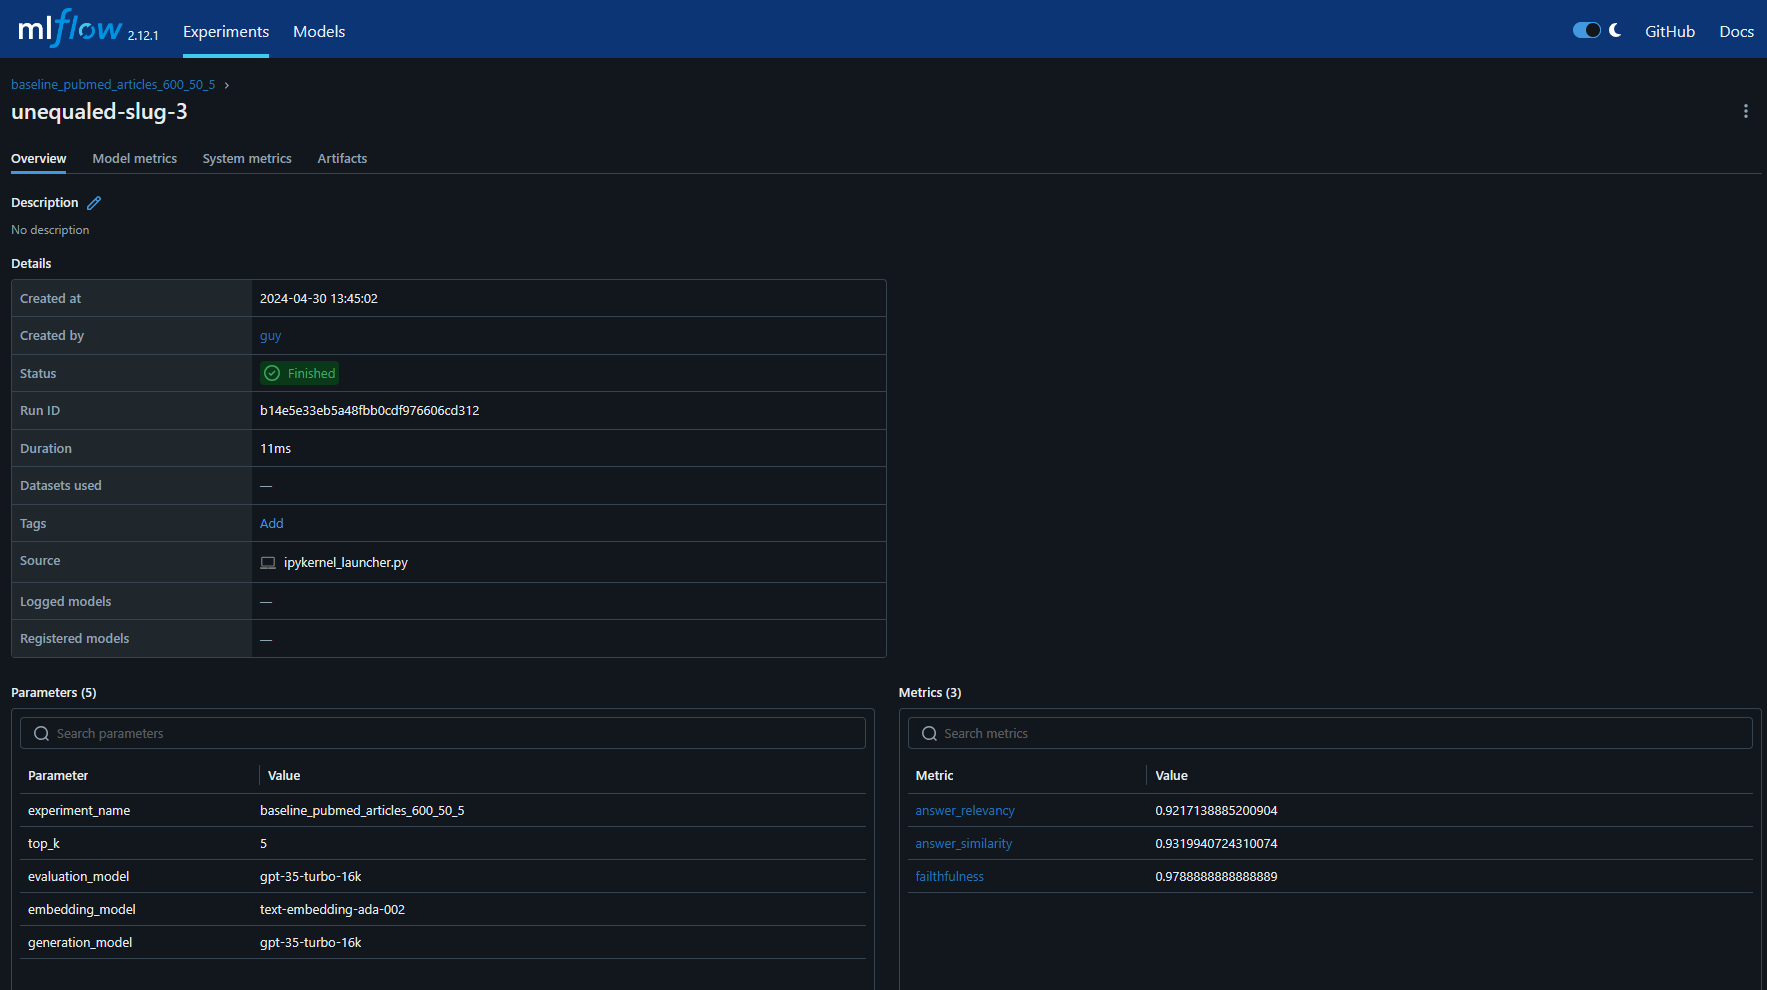